In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlglot

In [17]:
df = pd.read_json('data.json')
df.head()

,question,query,generation,retrieval_method,nshot,masked,no_literals,precision,recall,f1
0,what is warfarin sodium 2.5 mg po tabs's way o...,select distinct medication.routeadmin from med...,what is the ingesting method of warfarin sodium?,column_jaccard,1,True,False,0.808309,0.662931,0.728437
1,"what is the method for ingestion of ns 1,000 ml?",select distinct medication.routeadmin from med...,what is the ingesting method of niacin?,column_jaccard,1,True,False,0.728178,0.666734,0.696103
2,how is atorvastatin calcium 80 mg po tabs taken?,select distinct medication.routeadmin from med...,what is the name of the medication containing ...,column_jaccard,1,True,False,0.716453,0.668118,0.691442
3,what is metoprolol succinate er 50 mg po tb24'...,select distinct medication.routeadmin from med...,what is the prescribing doctor's name and the ...,column_jaccard,1,True,False,0.552028,0.427494,0.481845
4,tell me the price of a procedure called agent ...,select distinct cost.cost from cost where cost...,what is the price of a procedure named agent s...,column_jaccard,1,True,False,0.872670,0.864234,0.868431


In [18]:
results = {
    'retrieval_method': [],
    'nshot': [],
    'masked': [],
    'no_literals': [],
    'precision': [],
    'recall': [],
    'f1': [],
}

for retrieval_method, dff in df.groupby('retrieval_method'):
    for nshot, dfff in dff.groupby('nshot'):
        for masked, dffff in dfff.groupby('masked'):
            for no_literals, d in dffff.groupby('no_literals'):
                results['precision'].append(d['precision'].mean())
                results['recall'].append(d['recall'].mean())
                results['f1'].append(d['f1'].mean())
                results['retrieval_method'].append(retrieval_method)
                results['nshot'].append(nshot)
                results['masked'].append(masked)
                results['no_literals'].append(no_literals)
                
results = pd.DataFrame(results)

results.head()

,retrieval_method,nshot,masked,no_literals,precision,recall,f1
0,column_jaccard,1,False,False,0.715282,0.703185,0.707719
1,column_jaccard,1,False,True,0.582931,0.549687,0.564091
2,column_jaccard,1,True,False,0.699129,0.683665,0.689818
3,column_jaccard,1,True,True,0.561444,0.524465,0.540653
4,column_jaccard,2,False,False,0.748486,0.743061,0.744511


In [19]:
for no_literals, dff in results.groupby('no_literals'):
    for retrieval_method, dfff in dff.groupby('retrieval_method'):
        for masked, d in dfff.groupby('masked'):
            nshot = d['nshot'].to_list()
            recall = d['f1'].to_list()
            print(
                no_literals,
                retrieval_method,
                masked,
                np.round(nshot, 3),
                np.round(recall, 3)
                )

False column_jaccard False [1 2 3] [0.708 0.745 0.763]
False column_jaccard True [1 2 3] [0.69  0.732 0.755]
False random False [0 1 2 3] [0.533 0.621 0.645 0.662]
False random True [0 1 2 3] [0.514 0.603 0.615 0.632]
False tfidf False [1 2 3] [0.73  0.753 0.766]
False tfidf True [1 2 3] [0.713 0.738 0.755]
True column_jaccard False [1 2 3] [0.564 0.562 0.572]
True column_jaccard True [1 2 3] [0.541 0.553 0.564]
True random False [0 1 2 3] [0.477 0.524 0.525 0.525]
True random True [0 1 2 3] [0.453 0.503 0.507 0.51 ]
True tfidf False [1 2 3] [0.562 0.57  0.569]
True tfidf True [1 2 3] [0.55  0.555 0.561]


In [27]:
tokenizer = sqlglot.Tokenizer()
corrmap = df[df['no_literals'] == False]
corrmap['query_len'] = corrmap['query'].map(lambda i: len(tokenizer.tokenize(i)))
df[['precision', 'recall', 'f1', 'nshot', 'query_len']].corr(method='spearman')

/var/folders/dv/vl79wy215j9cf9q7y8n1r4_c0000gn/T/ipykernel_73660/1433299528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corrmap['query_len'] = corrmap['query'].map(lambda i: len(tokenizer.tokenize(i)))


,precision,recall,f1,nshot,query_len
precision,1.000000,0.863745,0.962184,0.257952,0.037119
recall,0.863745,1.000000,0.966492,0.206814,-0.062962
f1,0.962184,0.966492,1.000000,0.241486,-0.013129
nshot,0.257952,0.206814,0.241486,1.000000,0.000000
query_len,0.037119,-0.062962,-0.013129,0.000000,1.000000


In [ ]:
corrmap = df[df['no_literals'] == True]
corrmap['query_len'] = corrmap['query'].map(lambda i: len(tokenizer.tokenize(i)))
df[['precision', 'recall', 'f1', 'nshot', 'query_len']].corr(method='spearman')

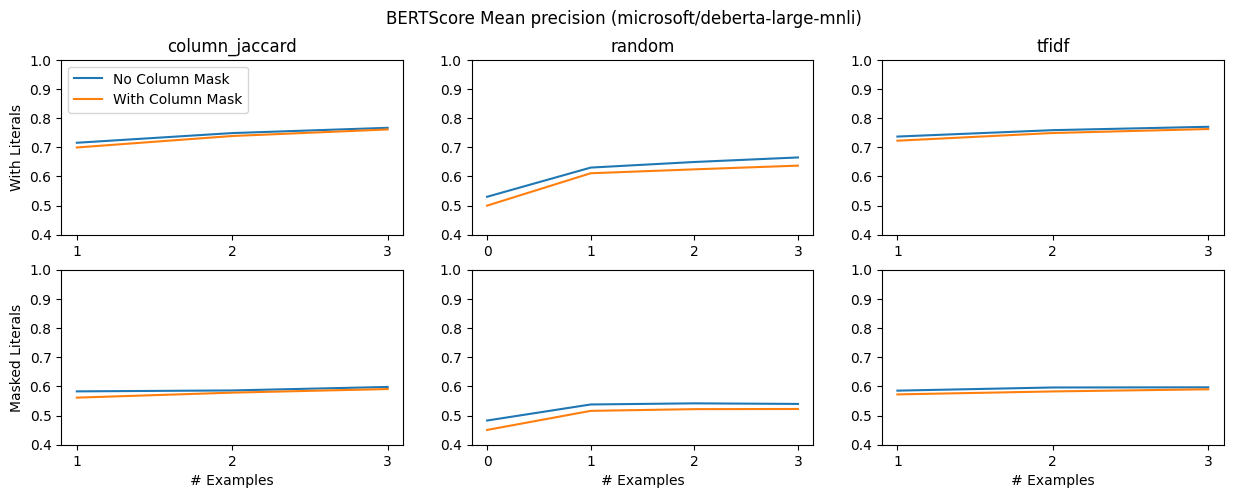

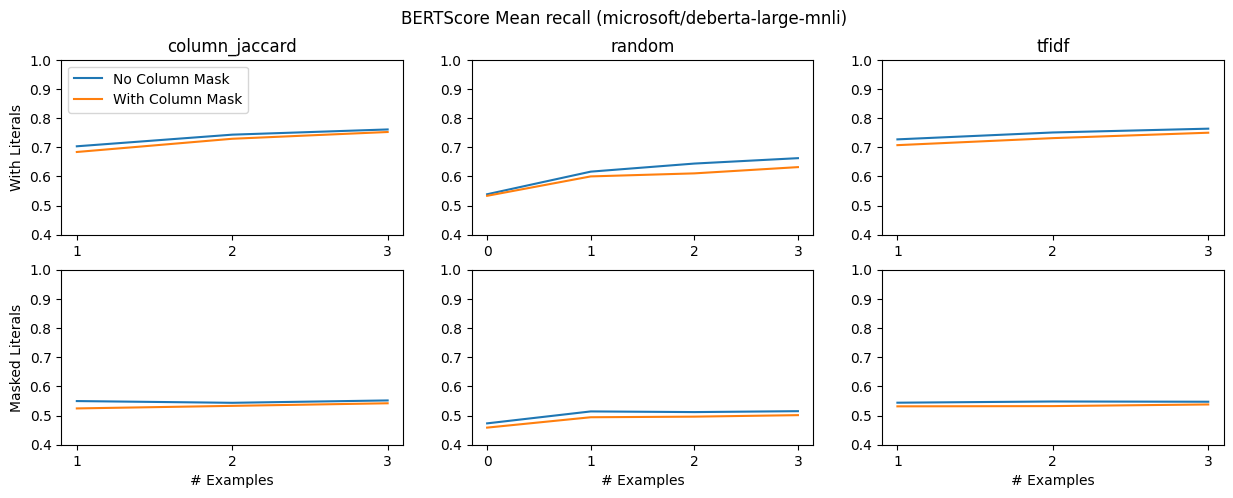

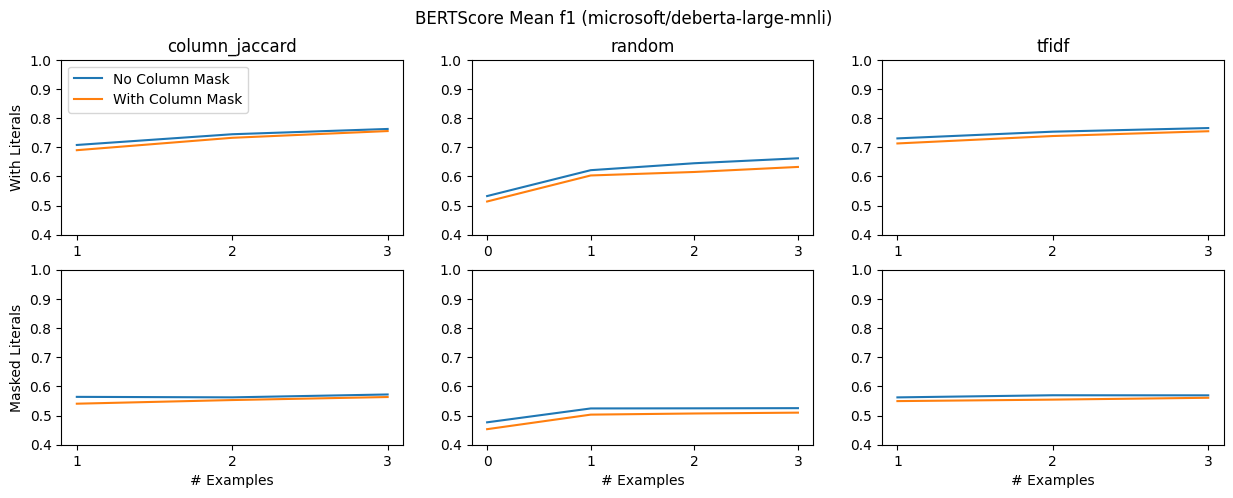

In [21]:
def generate_graph(metric : str = 'recall'):
    fig, ax = plt.subplots(2, 3, figsize=(15,5))
    for i, masked_literals in enumerate([False, True]):
        dff = results[results['no_literals'] == masked_literals]
        for j, retrieval_method in enumerate(results['retrieval_method'].unique()):
            d = dff[dff['retrieval_method'] == retrieval_method]
            with_mask = d[d['masked'] == True]
            no_mask = d[d['masked'] == False]
            
            ax[i][j].plot(no_mask['nshot'], no_mask[metric], label='No Column Mask')
            ax[i][j].plot(with_mask['nshot'], with_mask[metric], label='With Column Mask')
            
            ax[i][j].set_xticks(with_mask['nshot'])

            ax[i][j].set_ylim(.4, 1)

            if i == 1:
                ax[i][j].set_xlabel('# Examples')

            if j == 0:
                ax[i][j].set_ylabel('Masked Literals' if masked_literals else 'With Literals')
            
            if i == 0:
                ax[i][j].title.set_text(retrieval_method)

            if i == 0 and j == 0:
                ax[i][j].legend(loc='upper left')
        
        fig.suptitle(f'BERTScore Mean {metric} (microsoft/deberta-large-mnli)')

    sname = f'images/{metric}.png'
    plt.savefig(sname)
    plt.show()
    
for metric in ['precision', 'recall', 'f1']:
    generate_graph(metric=metric)